# Assignment 4 ----- hide unuseful code with sections (see test code). Comment code as well.

Johan Nicolaisen Brun and Filip Gornitzka Abelson



---






## Task 1: Object Detection Metrics

***a)*** When the network makes a prediction of where the object is, the area of the bounding box of the prediction which overlaps with the bounding box of the ground truth makes up the intersection and the total area of both bounding boxes makes up the union. To measure the accuracy of the prediction the divide the Intersection by the union.

![Intersection over union](https://i.ibb.co/0hJNB4z/iou.png)

Figure source: https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173

***b)*** A true positive is when the network marks a prediction as true when the object is withing the bounding box. A false positive is when the network marks a prediction as true when the object is not within the bounding box.

***c)*** **TP** = True positive, **TN** = True negative, **FP** = False positive, **FN** = False negative

\begin{align}
  Precision &= \frac{TP}{TP + FP} \\
  Recall &= \frac{TP}{TP + FN}
\end{align}

Precision tells us how many percent of our detections that are correct, as we calculate the ratio between the true positives and all positives detections. \\
Recall tells us how good we are at finding all the positives, as we calculate the ratio between true positives and all ground truths.

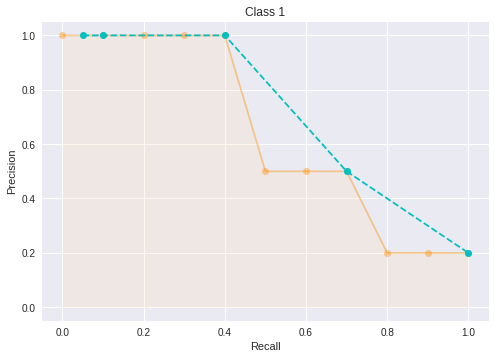

AP for class 1 is 0.645


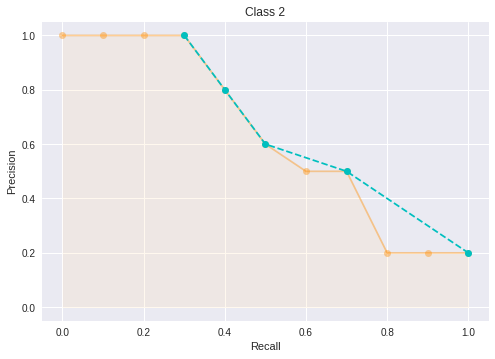

AP for class 2 is 0.636


==> mAP is 0.641


In [0]:
# A bit overkill for task 1, but we're basically using the same code again in task 2e). Had fun making a multi-class mAP calculator.

import numpy as np
import matplotlib.pyplot as plt

def calc_mAP (*args, plot = True, print_AP = True):
  '''
  *args consists of matrices where each row is a precision array 
  and recall array.
  
  Set plot = False to turn off plotting.
  
  print_AP = False turns off printing of AP for each class.
  
  '''  
  
  # Using around because of floating point error.
  recall_levels = [np.around(r*0.1,1) for r in range(0,11,1)]
  
  class_AP = []
  
  for num, array in enumerate(args):
    prc = np.array(array[0])
    rcl = np.array(array[1])
    
    assert prc.shape == rcl.shape, "Arrays are different shapes"
    
    max_prc_array = [] #Same shape as recall_levels
    
    for r in recall_levels:
      max_prc = 0
      for prc_val, r_marked in zip(prc, rcl):
        
        if r_marked >= r and prc_val >= max_prc:
          max_prc = prc_val
          
      max_prc_array.append(max_prc) 
      
    
    AP_val = np.average(max_prc_array)
    class_AP.append(AP_val)
    
    if plot == True:
      plt.plot(recall_levels, max_prc_array, marker="o", c="darkorange",alpha =0.4)
      plt.fill_between(recall_levels, max_prc_array, color="navajowhite", alpha=0.2)

      plt.plot(rcl, prc, '-o', c='c', linestyle='dashed')
      plt.xlabel('Recall')
      plt.ylabel('Precision')
      plt.title("Class {}".format(num+1))

      plt.show()
    
    if print_AP == True:
      print("AP for class {} is {:.3f}".format(num+1, AP_val))
    
  mAP = np.average(class_AP)
  
  return mAP
    
# Class 1
precision1 = [1.0, 1.0, 1.0, 0.5, 0.20]
recall1 = [0.05, 0.1, 0.4, 0.7, 1.0]

# Class 2
precision2 = [1.0, 0.80, 0.60, 0.5, 0.20]
recall2 = [0.3, 0.4, 0.5, 0.7, 1.0]

mAP = calc_mAP([precision1, recall1], [precision2, recall2])

print('\n')


print("==>", "mAP is {:.3f}".format(mAP))

## Task 2: Implementing Mean Average Precision 

Implementation of average precision for a single class.

###Code



Mean average precision: 0.9066


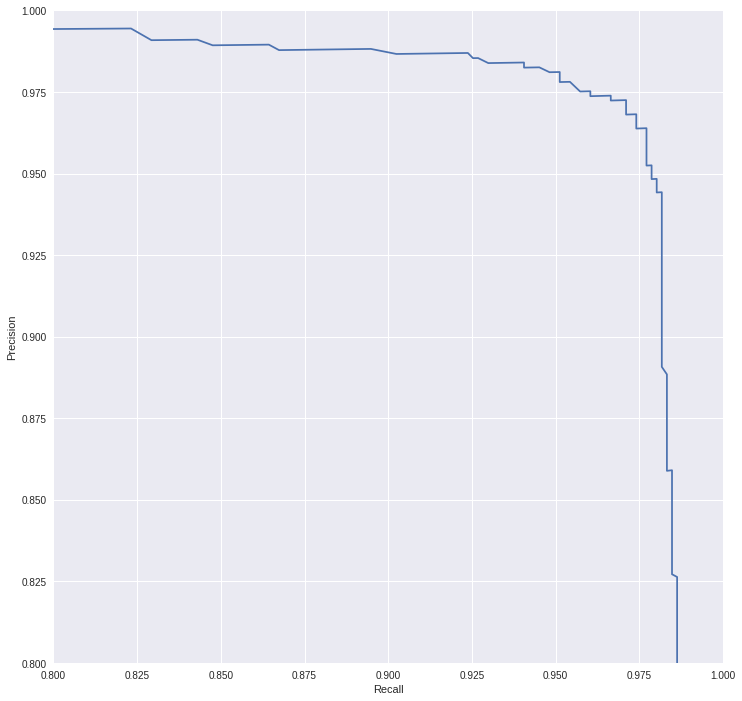

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import json
import copy
from task2_tools import read_predicted_boxes, read_ground_truth_boxes

def calculate_iou(prediction_box, gt_box):
    """Calculate intersection over union of single predicted and ground truth box.

    Args:
        prediction_box (np.array of floats): location of predicted object as
            [xmin, ymin, xmax, ymax]
        gt_box (np.array of floats): location of ground truth object as
            [xmin, ymin, xmax, ymax]

        returns:
            float: value of the intersection of union for the two boxes.
    
    
    (xmin, ymin)
    o----------------> x_axis
    |
    |
    |
    |
    |
    |
    v                o (xmax, ymax)
    y_axis
    
    """
    # Coordinates for overlap area
    x_left = max(prediction_box[0], gt_box[0])
    x_right = min(prediction_box[2], gt_box[2])
    y_top = max(prediction_box[1], gt_box[1])
    y_bottom = min(prediction_box[3], gt_box[3])
    
    # Check if we have overlap at all
    if x_left > x_right or y_top > y_bottom:
      return 0.0 # --> No overlap
    
    # Calculate overlap area
    overlap_area = (x_right - x_left) * (y_bottom - y_top)
    
    # Calculate area boxes and union area
    pred_area = (prediction_box[2] - prediction_box[0]) * (prediction_box[3] - prediction_box[1]) 
    gt_area = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])
    union_area = pred_area + gt_area - overlap_area
    
    # Calculate and return IoU
    iou = overlap_area / float(union_area)
    
    assert 0 <= iou <= 1, "iou not in range"
    
    return iou

def calculate_precision(num_tp, num_fp, num_fn):
    """ Calculates the precision for the given parameters.
        Returns 1 if num_tp + num_fp = 0

    Args:
        num_tp (float): number of true positives
        num_fp (float): number of false positives
        num_fn (float): number of false negatives
    Returns:
        float: value of precision
    """
    if num_tp + num_fp == 0:
      return 1
    else:
      return num_tp/float(num_tp + num_fp)


def calculate_recall(num_tp, num_fp, num_fn):
    """ Calculates the recall for the given parameters.
        Returns 0 if num_tp + num_fn = 0
    Args:
        num_tp (float): number of true positives
        num_fp (float): number of false positives
        num_fn (float): number of false negatives
    Returns:
        float: value of recall
    """
    if num_tp + num_fn == 0:
      return 0
    else:
      return num_tp/float(num_tp + num_fn)


def get_all_box_matches(prediction_boxes, gt_boxes, iou_threshold):
    """Finds all possible matches for the predicted boxes to the ground truth boxes.
        No bounding box can have more than one match.

        Remember: Matching of bounding boxes should be done with decreasing IoU order!

    Args:
        prediction_boxes: (np.array of floats): list of predicted bounding boxes
            shape: [number of predicted boxes, 4].
            Each row includes [xmin, ymin, xmax, ymax]
        gt_boxes: (np.array of floats): list of bounding boxes ground truth
            objects with shape: [number of ground truth boxes, 4].
            Each row includes [xmin, ymin, xmax, ymax]
    Returns the matched boxes (in corresponding order):
        prediction_boxes: (np.array of floats): list of predicted bounding boxes
            shape: [number of box matches, 4].
        gt_boxes: (np.array of floats): list of bounding boxes ground truth
            objects with shape: [number of box matches, 4].
            Each row includes [xmin, ymin, xmax, ymax]
    """
    
    match_pred = []
    match_gt = []
    
    for gt_box in gt_boxes:
      best_iou = 0
      best_pred_box = None
      
      for pred_box in prediction_boxes:
        iou = calculate_iou(pred_box, gt_box)
        if iou >= iou_threshold and iou > best_iou:
          best_pred_box = pred_box
          best_iou = iou
      
      # No matching pred.box
      if best_pred_box is not None:
        match_pred.append(best_pred_box)
        match_gt.append(gt_box)

    #Convert to numpy arrays    
    return (np.array(match_pred), np.array(match_gt))
    
    
    # Find all possible matches with a IoU >= iou threshold

    # Sort all matches on IoU in descending order

    # Find all matches with the highest IoU threshold
    

def calculate_individual_image_result(
        prediction_boxes, gt_boxes, iou_threshold):
    """Given a set of prediction boxes and ground truth boxes,
       calculates true positives, false positives and false negatives
       for a single image.
       NB: prediction_boxes and gt_boxes are not matched!

    Args:
        prediction_boxes: (np.array of floats): list of predicted bounding boxes
            shape: [number of predicted boxes, 4].
            Each row includes [xmin, ymin, xmax, ymax]
        gt_boxes: (np.array of floats): list of bounding boxes ground truth
            objects with shape: [number of ground truth boxes, 4].
            Each row includes [xmin, ymin, xmax, ymax]
    Returns:
        dict: containing true positives, false positives, false negatives
            {"true_pos": int, "false_pos": int, "false_neg": int}
    """
    
    # Find the bounding box matches with the highes IoU threshold
    match_pred, match_gt = get_all_box_matches(prediction_boxes, gt_boxes, iou_threshold)
    
    # Compute true positives, false positives, false negatives
    num_true_pos = match_pred.shape[0]
    num_false_pos = prediction_boxes.shape[0] - num_true_pos
    num_false_neg = gt_boxes.shape[0] - num_true_pos
    
    return  {"true_pos": num_true_pos, "false_pos": num_false_pos, "false_neg": num_false_neg}

def calculate_precision_recall_all_images(
        all_prediction_boxes, all_gt_boxes, iou_threshold):
    """Given a set of prediction boxes and ground truth boxes for all images,
       calculates recall and precision over all images.
       
       NB: all_prediction_boxes and all_gt_boxes are not matched!

    Args:
        all_prediction_boxes: (list of np.array of floats): each element in the list
            is a np.array containing all predicted bounding boxes for the given image
            with shape: [number of predicted boxes, 4].
            Each row includes [xmin, xmax, ymin, ymax]
        all_gt_boxes: (list of np.array of floats): each element in the list
            is a np.array containing all ground truth bounding boxes for the given image
            objects with shape: [number of ground truth boxes, 4].
            Each row includes [xmin, xmax, ymin, ymax]
    Returns:
        tuple: (precision, recall). Both float.
    """
    
    # Find total true positives, false positives and false negatives
    # over all images
    total_true_pos = 0
    total_false_pos = 0
    total_false_neg = 0
    
    ''' 
    INPUT --> res1, res2 = calculate_precision_recall_all_images([b1, b2], [b2, b2], 0.5)
    b2 = np.array([
        [0, 0, 1, 1],
        [0, 0, 1.5, 1.5],
        [3, 3, 4, 4],
        [5, 5, 8, 8]
    ])
    '''
    
    # Iterate over each image and add tp, fp, fn from each image to total.
    for img_pred_boxes, img_gt_boxes in zip(all_prediction_boxes, all_gt_boxes):
      num_dict = calculate_individual_image_result(img_pred_boxes, img_gt_boxes, iou_threshold)
      
      total_true_pos += num_dict["true_pos"]
      total_false_pos += num_dict["false_pos"]
      total_false_neg += num_dict["false_neg"]
    
    
    # Compute precision, recall
    prc = calculate_precision(total_true_pos, total_false_pos, total_false_neg)
    rcl = calculate_recall(total_true_pos, total_false_pos, total_false_neg)
    
    return (prc, rcl)

def get_precision_recall_curve(all_prediction_boxes, all_gt_boxes,
                               confidence_scores, iou_threshold):
    """Given a set of prediction boxes and ground truth boxes for all images,
       calculates the precision-recall curve over all images. Use the given
       confidence thresholds to find the precision-recall curve.

       NB: all_prediction_boxes and all_gt_boxes are not matched!

    Args:
        all_prediction_boxes: (list of np.array of floats): each element in the list
            is a np.array containing all predicted bounding boxes for the given image
            with shape: [number of predicted boxes, 4].
            Each row includes [xmin, xmax, ymin, ymax]
        all_gt_boxes: (list of np.array of floats): each element in the list
            is a np.array containing all ground truth bounding boxes for the given image
            objects with shape: [number of ground truth boxes, 4].
            Each row includes [xmin, xmax, ymin, ymax]
        scores: (list of np.array of floats): each element in the list
            is a np.array containting the confidence score for each of the
            predicted bounding box. Shape: [number of predicted boxes]

            E.g: score[0][1] is the confidence score for a predicted bounding box 1 in image 0.
    Returns:
        tuple: (precision, recall). Both np.array of floats.
    """
    # Instead of going over every possible confidence score threshold to compute the PR
    # curve, we will use an approximation
    # DO NOT CHANGE. If you change this, the tests will not pass when we run the final
    # evaluation
    confidence_thresholds = np.linspace(0, 1, 500)
    
    # YOUR CODE HERE
    
    #INPUT s = np.array([0.4, 0.7, 0.6, 0.9]), scores = [s,s]
    
    precision = []
    recall = []
    
    # Sort out predictions with confidence below threshold 
    for c_t in confidence_thresholds:
      img_pred_array = []
      for img_num, pred_boxes in enumerate(all_prediction_boxes):
        pred_array = []
        for box_num, pred_box in enumerate(pred_boxes):

            if confidence_scores[img_num][box_num] >= c_t:
              pred_array.append(pred_box)

        pred_array = np.array(pred_array)      
        img_pred_array.append(pred_array)
      
      img_pred_array = np.array(img_pred_array)
      
      prc, rcl = calculate_precision_recall_all_images(img_pred_array, all_gt_boxes, iou_threshold)
      
      precision.append(prc)
      recall.append(rcl)
      
    return (np.array(precision), np.array(recall))
  
    
'''For all possible confidence thresholds t:
• Find all predictions with a confidence >= t
• Calculate precision & recall for these predictions
'''

def plot_precision_recall_curve(precisions, recalls):
    """Plots the precision recall curve.
        Save the figure to precision_recall_curve.png:
        'plt.savefig("precision_recall_curve.png")'

    Args:
        precisions: (np.array of floats) length of N
        recalls: (np.array of floats) length of N
    Returns:
        None
    """
    # No need to edit this code.
    plt.figure(figsize=(12,12))
    plt.plot(recalls, precisions)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.xlim([0.8, 1.0])
    plt.ylim([0.8, 1.0])
    plt.savefig("precision_recall_curve.png")


def calculate_mean_average_precision(precisions, recalls):
    """ Given a precision recall curve, calculates the mean average
        precision.

    Args:
        precisions: (np.array of floats) length of N
        recalls: (np.array of floats) length of N
    Returns:
        float: mean average precision
    """
    # Calculate the mean average precision given these recall levels.
    # DO NOT CHANGE. If you change this, the tests will not pass when we run the final
    # evaluation
    recall_levels = np.linspace(0, 1.0, 11)
    
    # YOUR CODE HERE
    max_prc_array = [] # Same shape as recall_levels
    
    for r in recall_levels:
      max_prc = 0
      for prc, r_marked in zip(precisions, recalls):
        if r_marked >= r and prc >= max_prc:
          max_prc = prc
      max_prc_array.append(max_prc)
    
    mAP = np.average(max_prc_array)
    
    return mAP  
    


def mean_average_precision(ground_truth_boxes, predicted_boxes):
    """ Calculates the mean average precision over the given dataset
        with IoU threshold of 0.5

    Args:
        ground_truth_boxes: (dict)
        {
            "img_id1": (np.array of float). Shape [number of GT boxes, 4]
        }
        predicted_boxes: (dict)
        {
            "img_id1": {
                "boxes": (np.array of float). Shape: [number of pred boxes, 4],
                "scores": (np.array of float). Shape: [number of pred boxes]
            }
        }
    """
    # DO NOT EDIT THIS CODE
    all_gt_boxes = []
    all_prediction_boxes = []
    confidence_scores = []

    for image_id in ground_truth_boxes.keys():
        pred_boxes = predicted_boxes[image_id]["boxes"]
        scores = predicted_boxes[image_id]["scores"]

        all_gt_boxes.append(ground_truth_boxes[image_id])
        all_prediction_boxes.append(pred_boxes)
        confidence_scores.append(scores)
    iou_threshold = 0.5
    precisions, recalls = get_precision_recall_curve(all_prediction_boxes,
                                                     all_gt_boxes,
                                                     confidence_scores,
                                                     iou_threshold)
    plot_precision_recall_curve(precisions, recalls)
    mean_average_precision = calculate_mean_average_precision(precisions,
                                                              recalls)
    print("Mean average precision: {:.4f}".format(mean_average_precision))
    

if __name__ == "__main__":
    ground_truth_boxes = read_ground_truth_boxes()
    predicted_boxes = read_predicted_boxes()
    mean_average_precision(ground_truth_boxes, predicted_boxes)


### Tests

#### Test Code

In [0]:

def test_iou():
    print("="*80)
    print("Running tests for calculate_iou_individual_image")
    b1 = np.array([0, 0, 1, 1])
    b2 = np.array([1.0, 1.0, 2, 2])

    res = calculate_iou(b1, b2)
    ans = 0
    assert res == ans, "Expected {}, got: {}".format(ans, res)
    b1 = np.array([2, 1, 4, 3])
    b2 = np.array([1, 2, 3, 4])

    res = calculate_iou(b1, b2)
    ans = 1/7
    assert res == ans, "Expected {}, got: {}".format(ans, res)

    b1 = np.array([0, 0, 1, 1])
    b2 = np.array([0, 0, 1, 1])
    res = calculate_iou(b1, b2)
    ans = 1.0
    assert res == ans, "Expected {}, got: {}".format(ans, res)

    b1 = np.array([0, 0, 1, 1])
    b2 = np.array([0.5, 0.5, 1, 1])
    res = calculate_iou(b1, b2)
    ans = 0.25
    assert res == ans, "Expected {}, got: {}".format(ans, res)

    b1 = np.array([5.5, 5.5, 8, 8])
    b2 = np.array([5.5, 3, 8, 4])
    res = calculate_iou(b1, b2)
    ans = 0.0
    assert res == ans, "Expected {}, got: {}".format(ans, res)

    b1 = np.array([5.5, 5.5, 8, 8])
    b2 = np.array([3, 5.5, 4, 9])
    res = calculate_iou(b1, b2)
    ans = 0.0
    assert res == ans, "Expected {}, got: {}".format(ans, res)

    b1 = np.array([522, 540, 576, 660])
    b2 = np.array([520, 540, 570, 655])
    res = round(calculate_iou(b1, b2), 5)
    ans = 0.82265
    assert res == ans, "Expected {}, got: {}".format(ans, res)


def test_precision():
    print("="*80)
    print("Running tests for calculate_precision")
    ans = 1
    res = calculate_precision(0, 0, 0)
    assert res == ans, "Expected {}, got: {}".format(ans, res)

    res = calculate_precision(10, 20, 0)
    ans = 1/3
    assert res == ans, "Expected {}, got: {}".format(ans, res)


def test_recall():
    print("="*80)
    print("Running tests for calculate_recall")
    ans = 0
    res = calculate_recall(0, 0, 0)
    assert res == ans, "Expected {}, got: {}".format(ans, res)

    res = calculate_recall(10, 0, 30)
    ans = 1/4
    assert res == ans, "Expected {}, got: {}".format(ans, res)


def test_get_all_box_matches():
    print("="*80)
    print("Running tests for get_all_box_matches")
    b1 = np.array([
        [0, 0, 1, 1]
    ])
    b2 = np.array([
        [0, 0, 1, 1]
    ])
    res1, res2 = get_all_box_matches(b1, b2, 0.5)
    assert np.all(res1 == b1)
    assert np.all(res2 == b2)
    res1, res2 = get_all_box_matches(b1, b2, 1)
    assert np.all(res1 == b1)
    assert np.all(res2 == b2)

    b2 = np.array([
        [0, 0, 1, 1],
        [0.25, 0.25, 1, 1]
    ])
    res1, res2 = get_all_box_matches(b1, b2, 1)
    assert np.all(res1 == b1)
    assert np.all(res2 == b2[0:1])

    b2 = np.array([
        [0.25, 0.25, 1, 1],
        [0, 0, 1, 1]
    ])
    res1, res2 = get_all_box_matches(b1, b2, 1)
    assert np.all(res1 == b1)
    assert np.all(res2 == b2[1:2])

    res1, res2 = get_all_box_matches(np.array([]), np.array([]), 0.5)
    assert res1.size == 0
    assert res2.size == 0


def test_calculate_individual_image_result():
    print("="*80)
    print("Running tests for calculate_individual_image_result")
    b1 = np.array([
        [0, 0, 1, 1],
        [0.5, 0.5, 1.5, 1.5],
        [2, 2, 3, 3],
        [5.5, 5.5, 8, 8]
    ])
    b2 = np.array([
        [0, 0, 1, 1],
        [0, 0, 1.5, 1.5],
        [3, 3, 4, 4],
        [5, 5, 8, 8]
    ])
    np.random.shuffle(b1)
    np.random.shuffle(b2)
    ans1 = 2
    ans2 = 2
    ans3 = 2
    res = calculate_individual_image_result(b1, b2, 0.5)

    assert res["true_pos"] == ans1, "Expected {}, got: {}".format(
        ans1, res["true_pos"])
    assert res["false_pos"] == ans2, "Expected {}, got: {}".format(
        ans2, res["false_pos"])
    assert res["false_neg"] == ans3, "Expected {}, got: {}".format(
        ans3, res["false_neg"])


def test_calculate_precision_recall_all_images():
    print("="*80)
    print("Running tests for calculate_precision_recall_all_images")
    b1 = np.array([
        [0, 0, 1, 1],
        [0.5, 0.5, 1.5, 1.5],
        [2, 2, 3, 3],
        [5.5, 5.5, 8, 8]
    ])
    b2 = np.array([
        [0, 0, 1, 1],
        [0, 0, 1.5, 1.5],
        [3, 3, 4, 4],
        [5, 5, 8, 8]
    ])
    np.random.shuffle(b1)
    np.random.shuffle(b2)
    ans1 = 6/8
    ans2 = 6/8
    res1, res2 = calculate_precision_recall_all_images([b1, b2], [b2, b2], 0.5)
    assert res1 == ans1, "Expected {}, got: {}".format(ans1, res1)
    assert res2 == ans2, "Expected {}, got: {}".format(ans2, res2)


def test_get_precision_recall_curve():
    print("="*80)
    print("Running tests for get_precision_recall_curve")
    b1 = np.array([
        [0, 0, 1, 1],
        [0.5, 0.5, 1.5, 1.5],
        [2, 2, 3, 3],
        [5.5, 5.5, 8, 8]
    ])
    b2 = np.array([
        [0, 0, 1, 1],
        [0, 0, 1.5, 1.5],
        [3, 3, 4, 4],
        [5, 5, 8, 8]
    ])
    s = np.array([0.4, 0.7, 0.6, 0.9])
    ans1 = 404
    ans2 = 243
    res1, res2 = get_precision_recall_curve([b1, b2], [b2, b2], [s, s], 0.5)
    res1 = int(res1.sum())
    res2 = int(res2.sum())
    assert res1 == ans1, "Expected {}, got: {}".format(ans1, res1)
    assert res2 == ans2, "Expected {}, got: {}".format(ans2, res2)


def test_mean_average_precision():
    print("="*80)
    print("Running tests for calculate_mean_average_precision")
    p = np.array([0.19620253, 0.38137083, 0.65555556, 0.81179423, 0.88598901,
                  0.93198263, 0.95386905, 0.9695586, 0.98397436, 1.])
    r = np.array([0.99237805, 0.99237805, 0.98932927, 0.98628049, 0.98323171,
                  0.98170732, 0.97713415, 0.97103659, 0.93597561, 0.])
    
    res1 = calculate_mean_average_precision(p, r)
    ans1 = 0.89598
    assert round(res1, 5) == ans1, "Expected {}, got: {}".format(ans1, res1)


#### Test Output

In [0]:
    test_iou()
    test_precision()
    test_recall()
    test_get_all_box_matches()
    test_calculate_individual_image_result()
    test_calculate_precision_recall_all_images()
    test_get_precision_recall_curve()
    test_mean_average_precision()    
    
    print("="*80)
    print("All tests OK.")

Running tests for calculate_iou_individual_image
Running tests for calculate_precision
Running tests for calculate_recall
Running tests for get_all_box_matches
Running tests for calculate_individual_image_result
Running tests for calculate_precision_recall_all_images
Running tests for get_precision_recall_curve
Running tests for calculate_mean_average_precision
All tests OK.


## Task 3: You Only Look Once



*   YOLO is spatially constrained by the fact that for each grid cell, it only predicts two boxes and have one class. This constraint makes it difficult for YOLO to predict objects that are close together as well as small object that appear in groups.
*   ***FALSE*** - Yolo sees entire images during training and test time.
* Fast YOLO uses a neural network with fewer convolutional layers (9 instead of 24) and fewer filters in those layers. Besides this, all other training and testing parameters are the same.
* Faster R-CNN VGG-16 is more accurate than YOLOv1, by approximately 10mAP, but is 6 times slower that YOLO.
